# **Packages and data**

In [1]:
import pandas as pd
import numpy as np
import os
import random

import seaborn as sns #for visualisation
import matplotlib.pyplot as plt #for visualisation

import librosa #For audio processing
import librosa.display
from  IPython.display import Audio
import soundfile as sf

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

import pickle

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Loading the data
y = np.load('./mfcc-10k/mfcc_labels.npy', allow_pickle=True)
X = np.load('./mfcc-10k/mfcc_features.npy', allow_pickle=True)


#Encoding the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Fixing seed
def reset_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)
reset_seeds()

#Dividing train/test set
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X, y_encoded = shuffle(X, y_encoded, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


# Transpose: (nb, n_mfcc, time) -> (nb, time, n_mfcc)
X_train = X_train.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)
X = X.transpose(0,2,1)


from tensorflow.keras.utils import to_categorical

num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

y = to_categorical(y_encoded, num_classes)

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

class CustomEarlyStoppingCallback(Callback):
    def __init__(self, acc_threshold=0.40, acc_epoch_limit=15,
                 overfit_threshold=0.3, overfit_patience=3):
        super().__init__()
        self.acc_threshold = acc_threshold
        self.acc_epoch_limit = acc_epoch_limit - 1  # epochs are zero-indexed
        self.overfit_threshold = overfit_threshold
        self.overfit_patience = overfit_patience
        self.overfit_counter = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')
        loss = logs.get('loss')

        # 1. stop if val_accuracy < acc_threshold after N epochs
        if epoch == self.acc_epoch_limit:
            if val_acc is not None and val_acc < self.acc_threshold:
                print(f"\n🔴 Anticipated stop : val_accuracy ({val_acc:.2%}) < {self.acc_threshold:.0%} after {epoch+1} epochs.")
                self.model.stop_training = True

        # 2. Stop if overrfitting detecting during N epochs
        if val_loss is not None and loss is not None:
            if val_loss - loss > self.overfit_threshold:
                self.overfit_counter += 1
                print(f"⚠️ Overfitting detected at {epoch+1}: val_loss - loss = {val_loss - loss:.4f} (count: {self.overfit_counter})")
                if self.overfit_counter >= self.overfit_patience:
                    print(f"\n🛑 nticipated stop : overfitting detected during {self.overfit_patience} consecutives epochs.")
                    self.model.stop_training = True
            else:
                self.overfit_counter = 0

def newEarlyStoping():
    return EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    )

# **Parametres tuning**

In [ ]:
#Constants:
number_trial = 15
number_epochs = 50

#### GRU - 2 layers

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

def build_model(hp):
    model = Sequential()

    # Number of neurons of the first layer
    model.add(GRU(units=hp.Int('unit_layer1', min_value=64, max_value=256, step=64),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.15)))

    # 2nd layer
    model.add(GRU(units=hp.Int('unit_layer2', min_value=16, max_value=128, step=16),
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.15)))

    # Dense final layer
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=96, step=16),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
reset_seeds()
early_stopping = newEarlyStoping() # Classic Early stopping
custom_stop = CustomEarlyStoppingCallback() # callback


tuner_gru_gru = kt.BayesianOptimization(
    build_model,  # function to build the model
    objective='val_accuracy',
    max_trials=number_trial,
    directory='tuner_bayes',
    project_name='gru_gru_audio_bayes'
)

#Runing the tuner
tuner_gru_gru.search(X_train, y_train,
             epochs=number_epochs,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping, custom_stop])

Trial 15 Complete [00h 03m 27s]
val_accuracy: 0.9279999732971191

Best val_accuracy So Far: 0.9284999966621399
Total elapsed time: 00h 50m 51s


In [ ]:
# Getting the 3 best models with their performances
best_gru_gru = sorted(
    tuner_gru_gru.oracle.trials.values(),
    key=lambda t: t.metrics.get_last_value('val_accuracy'),
    reverse=True
)[:3]

# Display
for i, trial in enumerate(best_gru_gru):
    print(f"\n🔧 Best configuration #{i+1} — Validation Accuracy : {trial.metrics.get_last_value('val_accuracy'):.2%}")

    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

# Saving for later
with open("best_gru_gru.pkl", "wb") as f:
    pickle.dump(best_gru_gru, f)


🔧 Best configuration #1 — Validation Accuracy : 92.85%
  unit_layer1: 256
  dropout1: 0.4
  unit_layer2: 128
  dropout2: 0.25
  dense_units: 16

🔧 Best configuration #2 — Validation Accuracy : 92.80%
  unit_layer1: 256
  dropout1: 0.4
  unit_layer2: 128
  dropout2: 0.1
  dense_units: 16

🔧 Best configuration #3 — Validation Accuracy : 91.30%
  unit_layer1: 128
  dropout1: 0.4
  unit_layer2: 128
  dropout2: 0.4
  dense_units: 96


In [ ]:
# Loading
with open("best_gru_gru.pkl", "rb") as f:
    best_gru_gru = pickle.load(f)

#### LSTM - 2 layers

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

def build_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('unit_layer1', min_value=64, max_value=256, step=64),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.15)))

    model.add(LSTM(units=hp.Int('unit_layer2', min_value=16, max_value=128, step=16),
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.15)))

    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=96, step=16),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
reset_seeds()
early_stopping = newEarlyStoping() # Classical early stopping
custom_stop = CustomEarlyStoppingCallback() # callback

tuner_lstm_lstm = kt.BayesianOptimization(
    build_model,  # function to build the model
    objective='val_accuracy',
    max_trials=number_trial,
    directory='tuner_bayes',
    project_name='lstm_lstm_audio_bayes'
)

tuner_lstm_lstm.search(X_train, y_train,
             epochs=number_epochs,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping, custom_stop])

Trial 15 Complete [00h 01m 27s]
val_accuracy: 0.23250000178813934

Best val_accuracy So Far: 0.8939999938011169
Total elapsed time: 00h 44m 57s


In [ ]:
# Getting the 3 best models with their performances
best_lstm_lstm = sorted(
    tuner_lstm_lstm.oracle.trials.values(),
    key=lambda t: t.metrics.get_last_value('val_accuracy'),
    reverse=True
)[:3]
# Display
for i, trial in enumerate(best_lstm_lstm):
    print(f"\n🔧 Best configuration #{i+1} — Validation Accuracy : {trial.metrics.get_last_value('val_accuracy'):.2%}")

    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

# Save
with open("best_lstm_lstm.pkl", "wb") as f:
    pickle.dump(best_lstm_lstm, f)


🔧 Best configuration #1 — Validation Accuracy : 89.40%
  unit_layer1: 192
  dropout1: 0.1
  unit_layer2: 48
  dropout2: 0.25
  dense_units: 32

🔧 Best configuration #2 — Validation Accuracy : 89.25%
  unit_layer1: 128
  dropout1: 0.4
  unit_layer2: 128
  dropout2: 0.25
  dense_units: 80

🔧 Best configuration #3 — Validation Accuracy : 89.20%
  unit_layer1: 256
  dropout1: 0.25
  unit_layer2: 80
  dropout2: 0.25
  dense_units: 80


#### GRU + LSTM

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

def build_model(hp):
    model = Sequential()

    model.add(GRU(units=hp.Int('unit_layer1', min_value=64, max_value=256, step=64),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.15)))

    model.add(LSTM(units=hp.Int('unit_layer2', min_value=16, max_value=128, step=16),
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.15)))

    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=96, step=16),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
reset_seeds()
early_stopping = newEarlyStoping() # Early stopping classique
custom_stop = CustomEarlyStoppingCallback() # callback

tuner_gru_lstm = kt.BayesianOptimization(
    build_model, #function to buid the model
    objective='val_accuracy',
    max_trials=number_trial,
    directory='tuner_bayes',
    project_name='gru_lstm_audio_bayes'
)

tuner_gru_lstm.search(X_train, y_train,
             epochs=number_epochs,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping, custom_stop])

Trial 15 Complete [00h 04m 53s]
val_accuracy: 0.8784999847412109

Best val_accuracy So Far: 0.9039999842643738
Total elapsed time: 01h 08m 07s


In [ ]:
# Getting the 3 best models with their performances
best_gru_lstm = sorted(
    tuner_gru_lstm.oracle.trials.values(),
    key=lambda t: t.metrics.get_last_value('val_accuracy'),
    reverse=True
)[:3]

# Display
for i, trial in enumerate(best_gru_lstm):
    print(f"\n🔧 Best configuration #{i+1} — Validation Accuracy : {trial.metrics.get_last_value('val_accuracy'):.2%}")

    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

# Loading
with open("best_gru_lstm.pkl", "wb") as f:
    pickle.dump(best_gru_lstm, f)


🔧 Best configuration #1 — Validation Accuracy : 90.40%
  unit_layer1: 192
  dropout1: 0.25
  unit_layer2: 16
  dropout2: 0.1
  dense_units: 32

🔧 Best configuration #2 — Validation Accuracy : 89.30%
  unit_layer1: 192
  dropout1: 0.25
  unit_layer2: 64
  dropout2: 0.4
  dense_units: 48

🔧 Best configuration #3 — Validation Accuracy : 89.30%
  unit_layer1: 256
  dropout1: 0.25
  unit_layer2: 32
  dropout2: 0.25
  dense_units: 64


#### LSTM + GRU

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

def build_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.Int('unit_layer1', min_value=64, max_value=256, step=64),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  return_sequences=True))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.15)))

    model.add(GRU(units=hp.Int('unit_layer2', min_value=16, max_value=128, step=16),
                  return_sequences=False))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.15)))

    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=96, step=16),
                    activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
reset_seeds()
early_stopping = newEarlyStoping() # Classical Early stopping
custom_stop = CustomEarlyStoppingCallback() # callback

tuner_lstm_gru = kt.BayesianOptimization(
    build_model,  # function to build the model
    objective='val_accuracy',
    max_trials=number_trial,
    directory='tuner_bayes',
    project_name='lstmgru_audio_bayes'
)

tuner_lstm_gru.search(X_train, y_train,
             epochs=number_epochs,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping, custom_stop])

Trial 15 Complete [00h 01m 29s]
val_accuracy: 0.22550000250339508

Best val_accuracy So Far: 0.9350000023841858
Total elapsed time: 00h 55m 54s


In [ ]:
# Getting the 3 best models with their performances
best_lstm_gru = sorted(
    tuner_lstm_gru.oracle.trials.values(),
    key=lambda t: t.metrics.get_last_value('val_accuracy'),
    reverse=True
)[:3]

# Display
for i, trial in enumerate(best_lstm_gru):
    print(f"\n🔧 Best configuration #{i+1} — Validation Accuracy : {trial.metrics.get_last_value('val_accuracy'):.2%}")

    for param, value in trial.hyperparameters.values.items():
        print(f"  {param}: {value}")

# Saving
with open("best_lstm_gru.pkl", "wb") as f:
    pickle.dump(best_lstm_gru, f)


🔧 Best configuration #1 — Validation Accuracy : 93.50%
  unit_layer1: 256
  dropout1: 0.4
  unit_layer2: 128
  dropout2: 0.25
  dense_units: 16

🔧 Best configuration #2 — Validation Accuracy : 93.20%
  unit_layer1: 256
  dropout1: 0.1
  unit_layer2: 80
  dropout2: 0.1
  dense_units: 16

🔧 Best configuration #3 — Validation Accuracy : 93.15%
  unit_layer1: 256
  dropout1: 0.4
  unit_layer2: 48
  dropout2: 0.25
  dense_units: 48


# **Training functions**

In [ ]:
""" Train the given model with the given seed and given data
"""
def train_model(model, seed, X_train, y_train, X_val, y_val):
  reset_seeds(seed)
  early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1)

  # Automatic saving of the best model (based on val_loss)
  checkpoint = ModelCheckpoint(
    'best_gru_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
    )

  history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    shuffle = False
  )
  return history


import time

""" Print the keys caracteristics from the histories
"""
def print_histories(histories):
  for i, history in enumerate(histories):
    val_accuracies = history.history.get('val_accuracy', [])
    val_losses = history.history.get('val_loss', [])

    if val_accuracies and val_losses:
        best_idx = max(range(len(val_accuracies)), key=lambda j: val_accuracies[j])
        best_val_acc = val_accuracies[best_idx]
        corresponding_val_loss = val_losses[best_idx]
        2
        print(f"📊 Modèle #{i+1} → val_accuracy: {best_val_acc:.4f} | val_loss: {corresponding_val_loss:.4f} | time {history.history['train_duration']:.2f} | nb_epochs = {len(history.history['loss'])}")
    else:
        print(f"⚠️ Model #{i+1} : missing data.")

### Gru Gru

In [ ]:
def build_gru_gru(nl1, drop1, nl2, drop2, ndense): #Return a Gru-Gru model with the specified values

  model = Sequential()
  model.add(GRU(nl1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(drop1))
  model.add(GRU(nl2, return_sequences=False))
  model.add(Dropout(drop2))
  model.add(Dense(ndense, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### LSTM-LSTM

In [ ]:
def build_lstm_lstm(nl1, drop1, nl2, drop2, ndense):

  model = Sequential()
  model.add(LSTM(nl1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(drop1))
  model.add(LSTM(nl2, return_sequences=False))
  model.add(Dropout(drop2))
  model.add(Dense(ndense, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

### GRU - LSTM

In [ ]:
def build_gru_lstm(nl1, drop1, nl2, drop2, ndense):

  model = Sequential()
  model.add(GRU(nl1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(drop1))
  model.add(LSTM(nl2, return_sequences=False))
  model.add(Dropout(drop2))
  model.add(Dense(ndense, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

###  LSTM-GRU

In [ ]:
def build_lstm_gru(nl1, drop1, nl2, drop2, ndense):

  model = Sequential()
  model.add(LSTM(nl1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(drop1))
  model.add(GRU(nl2, return_sequences=False))
  model.add(Dropout(drop2))
  model.add(Dense(ndense, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# **Training with k split validation**

The goal is to train each "configuration" 6 time with a different seed (to avoid initialization bias) and using 6-fold cross-validation (to avoid dataset bias).

In [ ]:
import time
def run_cross_validation(X, y, model_generator):
  histories = []

  for i in range(6):

    #Reseting the seed
    seed = i
    reset_seeds(seed)

    #Generating the fold
    n = len(X)
    num_folds = 6
    fold_size = n // num_folds
    val_start = i * fold_size
    val_end = (i + 1) * fold_size if i != num_folds - 1 else len(X)

    val_idx = list(range(val_start, val_end))
    train_idx = list(range(0, val_start)) + list(range(val_end, len(X)))

    # Split X, y
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    #Generating the model

    model = model_generator()

    start_time = time.time()
    history = train_model(model, seed, X_train, y_train, X_val, y_val)
    duration = time.time() - start_time  # ⏱️ end timer

    history.history['train_duration'] = duration  # ⏺️ add time to history
    histories.append(history)
  return histories

### GRU GRU

In [ ]:
def cg_gg1():
  return build_gru_gru(256, 0.4, 128, 0.25, 16)
def cg_gg2():
  return build_gru_gru(256, 0.4, 128, 0.1, 16)
def cg_gg3():
    return build_gru_gru(128, 0.4, 128, 0.4, 96)


h_gg = run_cross_validation(X, y, cg_gg1) # stand for history_gru_gru
h_gg += run_cross_validation(X,y,cg_gg2)
h_gg+= run_cross_validation(X,y,cg_gg3)

with open("history_gg.pkl", "wb") as f:
    pickle.dump(h_gg, f)

In [ ]:
with open("drive/MyDrive/Cours/Stage Pertamina/h_gg.pkl", "rb") as f:
    h_gg = pickle.load(f)

In [ ]:
print_histories(h_gg)

📊 Modèle #1 → val_accuracy: 0.9280 | val_loss: 0.2890 | time 171.84 | nb_epochs = 26
📊 Modèle #2 → val_accuracy: 0.9250 | val_loss: 0.2988 | time 191.06 | nb_epochs = 29
📊 Modèle #3 → val_accuracy: 0.9376 | val_loss: 0.2923 | time 206.11 | nb_epochs = 32
📊 Modèle #4 → val_accuracy: 0.9328 | val_loss: 0.3090 | time 213.74 | nb_epochs = 33
📊 Modèle #5 → val_accuracy: 0.9124 | val_loss: 0.3840 | time 125.67 | nb_epochs = 19
📊 Modèle #6 → val_accuracy: 0.9335 | val_loss: 0.2776 | time 172.33 | nb_epochs = 26
📊 Modèle #7 → val_accuracy: 0.9172 | val_loss: 0.3320 | time 165.49 | nb_epochs = 25
📊 Modèle #8 → val_accuracy: 0.9160 | val_loss: 0.3122 | time 152.45 | nb_epochs = 23
📊 Modèle #9 → val_accuracy: 0.9358 | val_loss: 0.3036 | time 218.39 | nb_epochs = 33
📊 Modèle #10 → val_accuracy: 0.9238 | val_loss: 0.3234 | time 210.25 | nb_epochs = 32
📊 Modèle #11 → val_accuracy: 0.9244 | val_loss: 0.3073 | time 132.27 | nb_epochs = 20
📊 Modèle #12 → val_accuracy: 0.9347 | val_loss: 0.3032 | time 2

### LSTM LSTM

In [ ]:
def cg_ll1():
  return build_lstm_lstm(192, 0.1, 48, 0.25, 32)
def cg_ll2():
  return build_lstm_lstm(128, 0.4, 128, 0.25, 80)
def cg_ll3():
  return build_lstm_lstm(256, 0.25, 80, 0.25, 80)


h_ll = run_cross_validation(X, y, cg_ll1)
h_ll += run_cross_validation(X,y,cg_ll2)
h_ll+= run_cross_validation(X,y,cg_ll3)

with open("drive/MyDrive/Cours/Stage Pertamina/h_ll.pkl", "wb") as f:
    pickle.dump(h_ll, f)

In [ ]:
with open("drive/MyDrive/Cours/Stage Pertamina/h_ll.pkl", "wb") as f:
    pickle.dump(h_ll, f)

In [ ]:
print_histories(h_ll)

📊 Modèle #1 → val_accuracy: 0.2803 | val_loss: 1.5740 | time 60.58 | nb_epochs = 9
📊 Modèle #2 → val_accuracy: 0.4094 | val_loss: 1.3965 | time 85.61 | nb_epochs = 13
📊 Modèle #3 → val_accuracy: 0.9202 | val_loss: 0.3755 | time 301.83 | nb_epochs = 47
📊 Modèle #4 → val_accuracy: 0.9238 | val_loss: 0.3223 | time 310.07 | nb_epochs = 48
📊 Modèle #5 → val_accuracy: 0.9004 | val_loss: 0.4366 | time 321.27 | nb_epochs = 50
📊 Modèle #6 → val_accuracy: 0.9108 | val_loss: 0.3456 | time 322.07 | nb_epochs = 50
📊 Modèle #7 → val_accuracy: 0.3193 | val_loss: 1.5105 | time 57.92 | nb_epochs = 9
📊 Modèle #8 → val_accuracy: 0.8914 | val_loss: 0.3769 | time 259.46 | nb_epochs = 42
📊 Modèle #9 → val_accuracy: 0.9130 | val_loss: 0.3648 | time 308.03 | nb_epochs = 50
📊 Modèle #10 → val_accuracy: 0.8974 | val_loss: 0.4237 | time 235.82 | nb_epochs = 38
📊 Modèle #11 → val_accuracy: 0.3812 | val_loss: 1.4327 | time 76.21 | nb_epochs = 12
📊 Modèle #12 → val_accuracy: 0.8928 | val_loss: 0.3924 | time 216.79 

### GRU-LSTM

In [ ]:
def cg_gl1():
  return build_gru_lstm(192, 0.25, 16, 0.1, 32)
def cg_gl2():
  return build_gru_lstm(192, 0.25, 64, 0.4, 48)
def cg_gl3():
  return build_gru_lstm(256, 0.25, 32, 0.25, 64)


h_gl = run_cross_validation(X, y, cg_gl1)
h_gl += run_cross_validation(X,y,cg_gl2)
h_gl+= run_cross_validation(X,y,cg_gl3)

with open("drive/MyDrive/Cours/Stage Pertamina/h_gl.pkl", "wb") as f:
    pickle.dump(h_gl, f)

In [ ]:
print_histories(h_gl)

📊 Modèle #1 → val_accuracy: 0.8884 | val_loss: 0.4507 | time 187.99 | nb_epochs = 29
📊 Modèle #2 → val_accuracy: 0.8800 | val_loss: 0.4971 | time 181.07 | nb_epochs = 28
📊 Modèle #3 → val_accuracy: 0.8721 | val_loss: 0.5208 | time 150.16 | nb_epochs = 23
📊 Modèle #4 → val_accuracy: 0.8715 | val_loss: 0.5024 | time 181.98 | nb_epochs = 28
📊 Modèle #5 → val_accuracy: 0.8788 | val_loss: 0.4697 | time 200.32 | nb_epochs = 31
📊 Modèle #6 → val_accuracy: 0.8820 | val_loss: 0.3895 | time 232.58 | nb_epochs = 36
📊 Modèle #7 → val_accuracy: 0.8830 | val_loss: 0.4149 | time 323.37 | nb_epochs = 50
📊 Modèle #8 → val_accuracy: 0.8920 | val_loss: 0.3855 | time 322.52 | nb_epochs = 50
📊 Modèle #9 → val_accuracy: 0.8824 | val_loss: 0.4199 | time 277.05 | nb_epochs = 43
📊 Modèle #10 → val_accuracy: 0.8661 | val_loss: 0.4565 | time 322.76 | nb_epochs = 50
📊 Modèle #11 → val_accuracy: 0.8938 | val_loss: 0.4137 | time 322.84 | nb_epochs = 50
📊 Modèle #12 → val_accuracy: 0.8365 | val_loss: 0.4794 | time 3

### LSTM-GRU

In [ ]:
def cg_lg1():
  return build_lstm_gru(256, 0.4, 128, 0.25, 16)
def cg_lg2():
  return build_lstm_gru(256, 0.1, 80, 0.1, 16)
def cg_lg3():
  return build_lstm_gru(256, 0.4, 48, 0.25, 48)


h_lg = run_cross_validation(X, y, cg_lg1)
h_lg += run_cross_validation(X,y,cg_lg2)
h_lg+= run_cross_validation(X,y,cg_lg3)

with open("drive/MyDrive/Cours/Stage Pertamina/h_lg.pkl", "wb") as f:
    pickle.dump(h_lg, f)

In [ ]:
print_histories(h_lg)

📊 Modèle #1 → val_accuracy: 0.1975 | val_loss: 1.6100 | time 60.79 | nb_epochs = 9
📊 Modèle #2 → val_accuracy: 0.2383 | val_loss: 1.6010 | time 58.76 | nb_epochs = 9
📊 Modèle #3 → val_accuracy: 0.9310 | val_loss: 0.2869 | time 157.85 | nb_epochs = 25
📊 Modèle #4 → val_accuracy: 0.9394 | val_loss: 0.2646 | time 208.91 | nb_epochs = 33
📊 Modèle #5 → val_accuracy: 0.9340 | val_loss: 0.2719 | time 189.76 | nb_epochs = 30
📊 Modèle #6 → val_accuracy: 0.2377 | val_loss: 1.5804 | time 64.88 | nb_epochs = 10
📊 Modèle #7 → val_accuracy: 0.3283 | val_loss: 1.5154 | time 71.52 | nb_epochs = 11
📊 Modèle #8 → val_accuracy: 0.9322 | val_loss: 0.2888 | time 183.85 | nb_epochs = 29
📊 Modèle #9 → val_accuracy: 0.9352 | val_loss: 0.3022 | time 171.83 | nb_epochs = 27
📊 Modèle #10 → val_accuracy: 0.2821 | val_loss: 1.5710 | time 58.87 | nb_epochs = 9
📊 Modèle #11 → val_accuracy: 0.9130 | val_loss: 0.3665 | time 165.84 | nb_epochs = 26
📊 Modèle #12 → val_accuracy: 0.9281 | val_loss: 0.2899 | time 209.16 | 

# **Comparison**

In [ ]:
#Loading with Cross validation
with open("history_gg.pkl", "rb") as f:
    gru_gru_histories = pickle.load(f)
with open("history_ll.pkl", "rb") as f:
    lstm_lstm_histories = pickle.load(f)
with open("dhistory_gl.pkl", "rb") as f:
    gru_lstm_histories = pickle.load(f)
with open("history_lg.pkl", "rb") as f:
    lstm_gru_histories = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
"""Return the metric in an array-like representation"""
def extract_metrics(histories):
    val_accuracies = []
    val_losses = []
    training_times = []
    epochs = []

    for history in histories:
        va = history.history.get('val_accuracy', [])
        vl = history.history.get('val_loss', [])
        tt = history.history['train_duration']
        training_times.append(tt)
        if va and vl:
            best_epoch = int(np.argmax(va))
            val_accuracies.append(va[best_epoch])
            val_losses.append(vl[best_epoch])
            epochs.append(len(history.history['val_loss']))
        else:
            val_accuracies.append(None)
            val_losses.append(None)
            training_times.append(None)
            epochs.append(None)

    return {
        'training_time': training_times,
        'val_accuracy': val_accuracies,
        'val_loss': val_losses,
        'epochs': epochs
    }

import numpy as np
def print_summary(metrics):
  print(f"⏰ Time : Avg - {np.mean(metrics['training_time']):.2f}s | standart_dev - {np.std(metrics['training_time']):.2f}s | Max - {np.max(metrics['training_time']):.3f}")
  print(f"🎯 Accuracy: Avg - {np.mean(metrics['val_accuracy']):.2f} | standart_dev - {np.std(metrics['val_accuracy']):.2f} | Max - {np.max(metrics['val_accuracy']):.3f}")
  print(f"❌ Loss: Avg - {np.mean(metrics['val_loss']):.2f} | standart_dev - {np.std(metrics['val_loss']):.2f} | Min - {np.min(metrics['val_loss']):.3f}")
  print(f"🔢 nb_epochs: Avg - {np.mean(metrics['epochs']):.2f} | standart_dev - {np.std(metrics['epochs']):.2f} | Max - {np.max(metrics['epochs']):.3f}")

In [4]:
data_gg = extract_metrics(gru_gru_histories)
data_ll = extract_metrics(lstm_lstm_histories)
data_gl = extract_metrics(gru_lstm_histories)
data_lg = extract_metrics(lstm_gru_histories)

In [ ]:
print(f"Summary Gru GRU ------------------------------")
print_summary(data_gg)
print(f"Summary LSTM LSTSM ------------------------------")
print_summary(data_ll)
print(f"Summary GRU LSTM ------------------------------")
print_summary(data_gl)
print(f"Summary LSTM GRU ------------------------------")
print_summary(data_lg)

Summary Gru GRU ------------------------------
⏰ Time : Avg - 189.21s | standart_dev - 49.93s | Max - 338.625
🎯 Accuracy: Avg - 0.92 | standart_dev - 0.01 | Max - 0.938
❌ Loss: Avg - 0.33 | standart_dev - 0.06 | Min - 0.278
🔢 nb_epochs: Avg - 28.39 | standart_dev - 7.39 | Max - 49.000
Summary LSTM LSTSM ------------------------------
⏰ Time : Avg - 246.38s | standart_dev - 99.58s | Max - 324.130
🎯 Accuracy: Avg - 0.76 | standart_dev - 0.25 | Max - 0.932
❌ Loss: Avg - 0.66 | standart_dev - 0.49 | Min - 0.272
🔢 nb_epochs: Avg - 38.50 | standart_dev - 15.53 | Max - 50.000
Summary GRU LSTM ------------------------------
⏰ Time : Avg - 240.55s | standart_dev - 59.34s | Max - 324.873
🎯 Accuracy: Avg - 0.88 | standart_dev - 0.01 | Max - 0.895
❌ Loss: Avg - 0.44 | standart_dev - 0.04 | Min - 0.382
🔢 nb_epochs: Avg - 37.11 | standart_dev - 9.25 | Max - 50.000
Summary LSTM GRU ------------------------------
⏰ Time : Avg - 149.80s | standart_dev - 68.51s | Max - 278.728
🎯 Accuracy: Avg - 0.71 | s

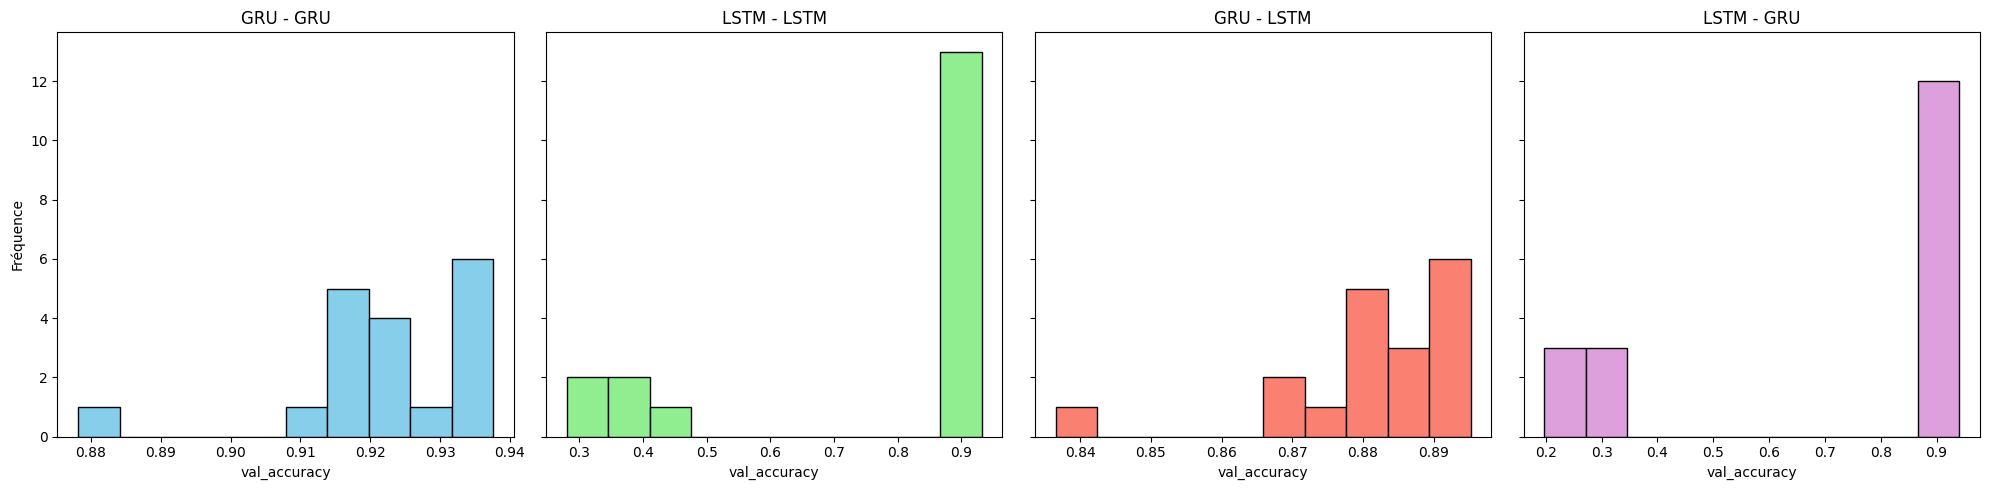

In [ ]:
import matplotlib.pyplot as plt

# Create 4 subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Histogram for GRU-GRU
axs[0].hist(data_gg['val_accuracy'], bins=10, color='skyblue', edgecolor='black')
axs[0].set_title("GRU - GRU")
axs[0].set_xlabel("val_accuracy")
axs[0].set_ylabel("Fréquence")

# Histogram for LSTM-LSTM
axs[1].hist(data_ll['val_accuracy'], bins=10, color='lightgreen', edgecolor='black')
axs[1].set_title("LSTM - LSTM")
axs[1].set_xlabel("val_accuracy")

# Histogram for GRU-LSTM
axs[2].hist(data_gl['val_accuracy'], bins=10, color='salmon', edgecolor='black')
axs[2].set_title("GRU - LSTM")
axs[2].set_xlabel("val_accuracy")

# Histogram for LSTM-GRU
axs[3].hist(data_lg['val_accuracy'], bins=10, color='plum', edgecolor='black')
axs[3].set_title("LSTM - GRU")
axs[3].set_xlabel("val_accuracy")

plt.tight_layout()
plt.show()

### Pair comparison

In [ ]:
"""Compare each metric from m1 with those of m2 to print which architecture is better."""
def comparison(metric1, metric2, name1, name2):
  win1 = 0
  win2 = 0
  n = len(metric1) * len(metric2)
  for a in metric1:
    for b in metric2:
      if a > b:
        win1+=1
      elif a < b:
        win2+=1

  print(f"{name1} is better in {(win1 / n *100):.1f} % compared to {name2} which is better in {(win2  / n * 100):.1f}%")

"""Same as the comparison() function but compare m1 with all the other algorithms."""
def full_comparison(metric1, metric2,  metric3, metric4, name):
  def comp(m1, m2):
    w = 0
    for a in m1:
      for b in m2:
        if a > b:
          w+=1
    return w
  n =  3 * len(metric1) * len(metric2)
  win = comp(metric1, metric2) + comp(metric1, metric3) + comp(metric1, metric4)
  print(f"{name} is better in {(win / n *100):.1f} % compared to all others architectures")



In [ ]:
comparison(data_gg["val_accuracy"], data_ll['val_accuracy'], 'GRU - GRU', 'LSTM - LSTM')
comparison(data_gg["val_accuracy"], data_lg['val_accuracy'], 'GRU - GRU', 'LSTM - GRU')
comparison(data_gg["val_accuracy"], data_gl['val_accuracy'], 'GRU - GRU', 'GRU - LSTM')
print("---")
comparison(data_ll["val_accuracy"], data_gg['val_accuracy'], 'LSTM - LSTM', 'GRU - GRU')
comparison(data_ll["val_accuracy"], data_lg['val_accuracy'], 'LSTM - LSTM', 'LSTM - GRU')
comparison(data_ll["val_accuracy"], data_gl['val_accuracy'], 'LSTM - LSTM', 'GRU - LSTM')
print("---")
comparison(data_lg["val_accuracy"], data_gg['val_accuracy'], 'LSTM - GRU', 'GRU - GRU')
comparison(data_lg["val_accuracy"], data_ll['val_accuracy'], 'LSTM - GRU', 'LSTM - LSTM')
comparison(data_lg["val_accuracy"], data_gl['val_accuracy'], 'LSTM - GRU', 'GRU - LSTM')
print("---")
comparison(data_gl["val_accuracy"], data_gg['val_accuracy'], 'GRU - LSTM', 'GRU - GRU')
comparison(data_gl["val_accuracy"], data_ll['val_accuracy'], 'GRU - LSTM', 'LSTM - LSTM')
comparison(data_gl["val_accuracy"], data_lg['val_accuracy'], 'GRU - LSTM', 'LSTM - GRU')
print("---")
print("Full comparison")
full_comparison(data_gg["val_accuracy"], data_ll['val_accuracy'],data_gl["val_accuracy"], data_lg['val_accuracy'], 'GRU  - GRU')
full_comparison(data_ll["val_accuracy"], data_gg['val_accuracy'],data_gl["val_accuracy"], data_lg['val_accuracy'], 'LSTM - LSTM')
full_comparison(data_gl["val_accuracy"], data_gg['val_accuracy'],data_ll["val_accuracy"], data_lg['val_accuracy'], 'GRU - LSTM')
full_comparison(data_lg["val_accuracy"], data_gg['val_accuracy'],data_gl["val_accuracy"], data_ll['val_accuracy'], 'LSTM - GRU')

GRU - GRU is better in 84.0 % compared to LSTM - LSTM which is better in 15.1%
GRU - GRU is better in 57.1 % compared to LSTM - GRU which is better in 42.0%
GRU - GRU is better in 95.7 % compared to GRU - LSTM which is better in 4.3%
---
LSTM - LSTM is better in 15.1 % compared to GRU - GRU which is better in 84.0%
LSTM - LSTM is better in 38.3 % compared to LSTM - GRU which is better in 61.1%
LSTM - LSTM is better in 70.4 % compared to GRU - LSTM which is better in 29.6%
---
LSTM - GRU is better in 42.0 % compared to GRU - GRU which is better in 57.1%
LSTM - GRU is better in 61.1 % compared to LSTM - LSTM which is better in 38.3%
LSTM - GRU is better in 66.7 % compared to GRU - LSTM which is better in 33.3%
---
GRU - LSTM is better in 4.3 % compared to GRU - GRU which is better in 95.7%
GRU - LSTM is better in 29.6 % compared to LSTM - LSTM which is better in 70.4%
GRU - LSTM is better in 33.3 % compared to LSTM - GRU which is better in 66.7%
---
Full comparison
GRU  - GRU is better i

## Friedman test

In [ ]:
from scipy.stats import friedmanchisquare

#extraction of the results
results = [
    data_gg['val_accuracy'],
    data_ll['val_accuracy'],
    data_gl['val_accuracy'],
    data_lg['val_accuracy'],
]

#Runing the Friedman test
stat, p = friedmanchisquare(*zip(*results))
print(f"Friedman stat = {stat:.4f}, p-value = {p:.4f}")

Friedman stat = 19.6937, p-value = 0.2902


## Visualisation

/tmp/ipython-input-1961703732.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["GRU-GRU", "LSTM-LSTM", "GRU-LSTM", "LSTM-GRU"], showmeans=True)


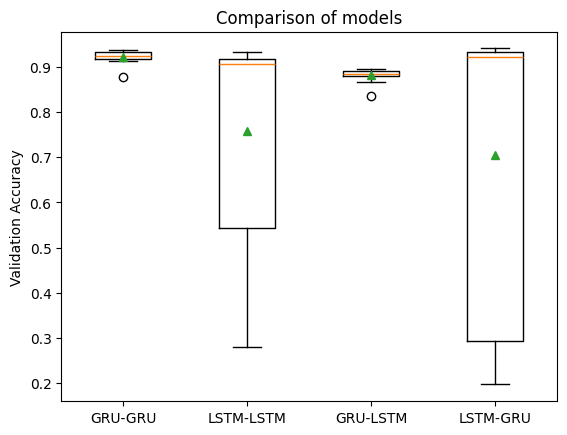

In [5]:
data = [
    data_gg['val_accuracy'],
    data_ll['val_accuracy'],
    data_gl['val_accuracy'],
    data_lg['val_accuracy'],
]

plt.boxplot(data, labels=["GRU-GRU", "LSTM-LSTM", "GRU-LSTM", "LSTM-GRU"], showmeans=True)

plt.ylabel("Validation Accuracy")
plt.title("Comparison of models")
plt.show()